In [ ]:
# !pip install ipympl > /dev/null
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## "Imports"
- ChunkedNPTStackReader
- butter_bandpass_filter(arr[:, 0], 20e3, 100e3, fs, 6)
- Est_ZC_stage_1

In [ ]:
import numpy as np
import struct

class ChunkedNPTStackReader:
    def __init__(self, filename, delimiter=','):
        self.filename = filename
        self.file = None
        self.time_len = struct.calcsize('<d')
        self.time_unpack = struct.Struct('<d').unpack_from

    def __enter__(self):
        print("Opening npstack file")
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
        return self

    def __iter__(self):
        return self

    def __next__(self):
        if self.file is None:
            raise Exception("Use the context manager interface with this object, i.e. ```with ChunkedNPStackReader('output.csv') as cr: ```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))
            arr = np.load(self.file)
            return t, arr
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def stream(self):
        return np.vstack([arr for arr in self])

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.file.close()


In [ ]:
import itertools

import numpy as np
from scipy.signal import lfilter, hilbert, iirfilter


def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = iirfilter(order, [low, high],
                     btype='bandpass', ftype='butter')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    signal = lfilter(b, a, data)
    return signal


# definition for signal normalisation in range -1 to +1
def normalisation(signal):
    signal = signal - signal.mean()
    signal = signal / signal.max()
    return signal


def filter_bandpass(signal, fs):
    lowcut = 41e3
    highcut = 43e3
    signal = np.array(signal)
    signal = butter_bandpass_filter(signal, lowcut, highcut, fs, order=6)
    signal_p = normalisation(signal)
    return signal_p


# TODO: how to deal with multiple sets of zero crossing,
# TODO: groupby can bre replaced my numpy indexing i think
# notes for function def stage_1(signal, winsize_zero_cross, fs, run_plot)
# stage 1 does the following processes:
# 1. filter use IIR bandpass filters
# 2. estimate the zero-crossing of the first peak in two stages
#    first of which is approximate position where first peak crosses the threshold of 10% of signal mean
#    second stage, wherein use curvature of the signal to estimate a more-accurate estimate of zero-crossing
# Availible defaults           500,1e6,                    0, 
def Est_ZC_stage_1(signal, winsize, fs, std_noise_multiplier, run_plot=False, plot_title='zero_crossing'):
    def sum_index(index_limit, reshaped_group_results_len):
        ind_count = 0
        for k in range(0, index_limit):
            ind_count = ind_count + reshaped_group_results_len[k]
        return ind_count

    def ZC_estimation(signal_h, noise_threshold, n_max_p):

        # estimate out part of the signal which is > threshold
        results = np.where(signal_h > noise_threshold, True, False)

        # itertools groupby aims to group the array in groups of True and False
        # where g is the groups and k is unique key/ value in each group
        # size/ length of the groups is given by len(list(g)) and is stored as an np.array
        group_results_len = np.array([len(list(g)) for k, g in itertools.groupby(results)])

        # only the first value of each groups (True or False) is stored in this array - will now correspond to each group
        # for which length are estimated previously
        group_results_value = np.array([list(g)[0] for k, g in itertools.groupby(results)])

        # indices & group-length wherein corresponding value in group_results_value is True
        ind_of_group_results_value_for_trues = np.array(np.where(group_results_value == True))
        group_len_counts_of_true = (group_results_len[ind_of_group_results_value_for_trues])

        # indices of top n_max maximuma of group_len_counts_of_true
        ind_n_max_group_len_counts_of_true = np.array(np.argsort(-group_len_counts_of_true))

        # manipulations to match the shape of the arrays
        group_len_counts_of_true = group_len_counts_of_true.T
        ind_n_max_group_len_counts_of_true = ind_n_max_group_len_counts_of_true.T

        # how many maxs (top-n) need to be estimated?
        n_max = int(len(group_len_counts_of_true) * n_max_p / 100)
        if n_max <= 2:
            n_max = int(len(group_len_counts_of_true))

        ind_n_max_group_len_counts_of_true = np.array(ind_n_max_group_len_counts_of_true[0:n_max])

        # what are the values of the top-n (sorted) group-lengths of trues?
        values_maxes_in_group_results_len = np.array((group_len_counts_of_true[ind_n_max_group_len_counts_of_true]))
        values_maxes_in_group_results_len = np.reshape(values_maxes_in_group_results_len, (n_max, 1))

        # manipulations to match the shape of the arrays
        reshaped_group_results_len = np.reshape(group_results_len, (len(group_results_len), 1))

        # elementwise comparison of the arrays to estimate the starting indices of the n_max groups of True:
        # comparison with the entire (true-false) list
        ind_of_max_in_group_results_len = np.array(np.where(np.in1d(reshaped_group_results_len,
                                                                    values_maxes_in_group_results_len)))

        index_max_counts_of_true = np.zeros((len(ind_of_max_in_group_results_len), 1))
        for i in range(len(ind_of_max_in_group_results_len)):
            try:
                index_max_counts_of_true[i] = sum_index(ind_of_max_in_group_results_len[i, 0],
                                                        reshaped_group_results_len) + 1
            except:
                index_max_counts_of_true[i] = 0
                break

        Q_zero_cross_index = (np.min(index_max_counts_of_true[:, 0])).astype(int)

        return Q_zero_cross_index

    def plot_ZC(signal_h, Q_zero_cross_index, plot_title, winsize):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Rectangle
        sig = signal_y
        index = Q_zero_cross_index
        fig, axs = plt.subplots(1, figsize=(12,4))
        fig.suptitle(plot_title)
        axs.plot(sig, label='bandpass')
        axs.plot(np.repeat(0, len(sig)), 'k--', label='zero level')
        axs.plot(np.repeat(noise_threshold_1, len(sig)), 'r--', label='noise_threshold_1')
        axs.plot(np.repeat(noise_threshold_2, len(sig)), 'b--', label='noise_threshold_2')
        axs.plot(index, sig[index], 'o')
        rect = Rectangle((index, 0), winsize * 2, np.max(sig) / 2, linewidth=3, edgecolor='r', facecolor='none')
        axs.add_patch(rect)
        axs.legend()

    # filter first and then, normalise the signal for further processing
    signal_y = filter_bandpass(signal, fs)

    # estimate the envelope of the rectified signal using the hilbert transform
    signal_h = np.abs(hilbert(signal_y))

    # estimate threshold
    threshold = (np.mean(signal_h))
    signal_noise_h = np.where(signal_h > threshold, 0, signal_h)
    noise_threshold_1 = np.mean(signal_noise_h) + std_noise_multiplier * np.std(signal_noise_h)
    # print('noise_threshold_1', noise_threshold_1)

    # first iteration 
    n_max_p = 5
    init_est_ZC_index = ZC_estimation(signal_h, noise_threshold_1, n_max_p)
    # print(f'init_est_ZC_index - {plot_title}', init_est_ZC_index)

    # attempt to check the samples in the neighbourhood
    hori_check_indices = np.linspace(init_est_ZC_index - winsize, init_est_ZC_index + winsize, winsize * 2, dtype=int)
    if np.all(signal_h[hori_check_indices] < 10 * noise_threshold_1):
        init_est_ZC_index = ZC_estimation(signal_h, noise_threshold_1 * 2, n_max_p)

    # attempt to check the samples in the neighbourhood by selecting a window with elevated threshold
    noise_threshold_2 = noise_threshold_1 * 1.25
    # print('noise_threshold_2', noise_threshold_2)
    second_est_ZC_index = 0
    if signal_h[init_est_ZC_index] >= 3 * noise_threshold_1:
        # second iteration 
        n_max_p = 50
        sub_signal = signal_h[init_est_ZC_index - winsize: init_est_ZC_index + winsize]
        ZC_subsignal = ZC_estimation(sub_signal, noise_threshold_2, n_max_p)
        # print(f'ZC_subsignal - {plot_title}', ZC_subsignal)
        second_est_ZC_index = init_est_ZC_index + (ZC_subsignal - winsize)
        # print(f'second_est_ZC_index - {plot_title}', second_est_ZC_index)

    if second_est_ZC_index != 0:
        ZC_index = second_est_ZC_index
    else:
        ZC_index = init_est_ZC_index

    if run_plot:
        plot_ZC(signal_h, ZC_index, plot_title, winsize)

    return ZC_index


## Get Data

In [ ]:
!ls "290921_full_tests.tar.xz" || gdown "https://drive.google.com/uc?id=1HVEhuDwrAt2ypB9J6pMpttu3sfGDPdcV"

290921_full_tests.tar.xz


In [ ]:
# import tarfile
# data_archive = tarfile.open(name='290921_full_tests.tar.xz', mode='r:xz')
# members = data_archive.getmembers()
# for i, m in enumerate (members):
#   print(i, m.name)
# input_file = data_archive.extractfile(members[5])

In [ ]:
# !tar xvf 290921_full_tests.tar.xz
# input_file = '290921_full_tests/pool_test1/pico.npts'

290921_full_tests/
290921_full_tests/pool_test1/
290921_full_tests/pool_test1/pico.npts
^C


In [ ]:
# input_file = 'tt2.npts'

In [ ]:
input_file = 'pico_1.npts'

In [ ]:
with ChunkedNPTStackReader(input_file) as file:
  arr = np.vstack(tuple(a[1] for a in file))
arr.shape

Opening npstack file


(5800000, 5)

In [ ]:
_[0]/(1e6)

5.8

In [ ]:
# data_archive.close()

In [ ]:
np.max(np.abs(arr)), arr.dtype

(2000, dtype('int16'))

In [ ]:
dt = 1e-6
fs = 1.0 / dt
print(f"dt={dt}\tfs={fs:.0f}Hz")
print(f"Total Time: {arr.shape[0] * dt:.2f}s")

t = np.arange(len(arr)) * dt

dt=1e-06	fs=1000000Hz
Total Time: 5.80s


## BandPass Tests

In [ ]:
from scipy.signal import iirfilter, sosfilt

In [ ]:
order = 6
pass_freqs = np.array((20e3, 50e3))

arr_filtered = sosfilt(
    iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='sos'), 
    arr)

In [ ]:
plt.figure(figsize=(12,3))
loc = slice(0, len(arr)//50)
_ = plt.plot(1000 * t[loc], arr_filtered[loc, :])#, label=list(np.arange(arr.shape[1])))
plt.legend(_, map(lambda x: f"Ch{x}", np.arange(arr.shape[1]) + 1))
plt.xlabel('T(ms)')
# plt.ylabel('A')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
loc = slice(0, len(arr)//10)
# channels = slice(0, arr.shape[1])
channels = slice(0, 5)
_ = plt.plot(1000 * t[loc], arr_filtered[loc,channels])#, label=list(np.arange(arr.shape[1])))
plt.legend(_, map(lambda x: f"Ch{x}", np.arange(arr.shape[1]) + 1), loc='lower right')
plt.xlabel('T(ms)')
# plt.ylabel('A')
plt.show()

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

loc = slice(0, len(arr)//5)
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("T(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(20,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

loc = slice(0, len(arr)//50)
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(1000 * t[loc], row[loc], label=f"Ch{i+1}", color=color)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("T(ms)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(20,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

loc = slice(0, len(arr)//100)
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(1000 * t[loc], row[loc], label=f"Ch{i+1}", color=color)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("T(ms)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
order = 6
pass_freqs = np.array((20, 20.01)) * int(1e3)
 
arr_filtered = sosfilt(
    iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='sos'), 
    arr)

In [ ]:
plt.figure(figsize=(12,3))

plt.plot(t[:len(arr)//100], arr_filtered[:len(arr)//100, :])

plt.show()

In [ ]:
order = 6
pass_freqs = np.array((200, 200.01)) * int(1e3)
 
arr_filtered = sosfilt(
    iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='sos'), 
    arr)

In [ ]:
plt.figure(figsize=(12,3))

plt.plot(t[:len(arr)//100], arr_filtered[:len(arr)//100, :])

plt.show()

## Bandpass better

In [ ]:
from scipy.signal import iirfilter, sosfilt

In [ ]:
arr.mean(axis=0)

array([-2.01782805e+02, -1.92256579e+02, -1.75069420e+02,  7.44519085e-02,
       -1.05052654e+02])

In [ ]:
order = 6
pass_freqs = np.array((4e3, 44e3))

arr_filtered = sosfilt(
    iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='sos'), 
    arr[int(5*fs):int(10*fs)] - arr[int(5*fs):int(10*fs)].mean(axis=0))

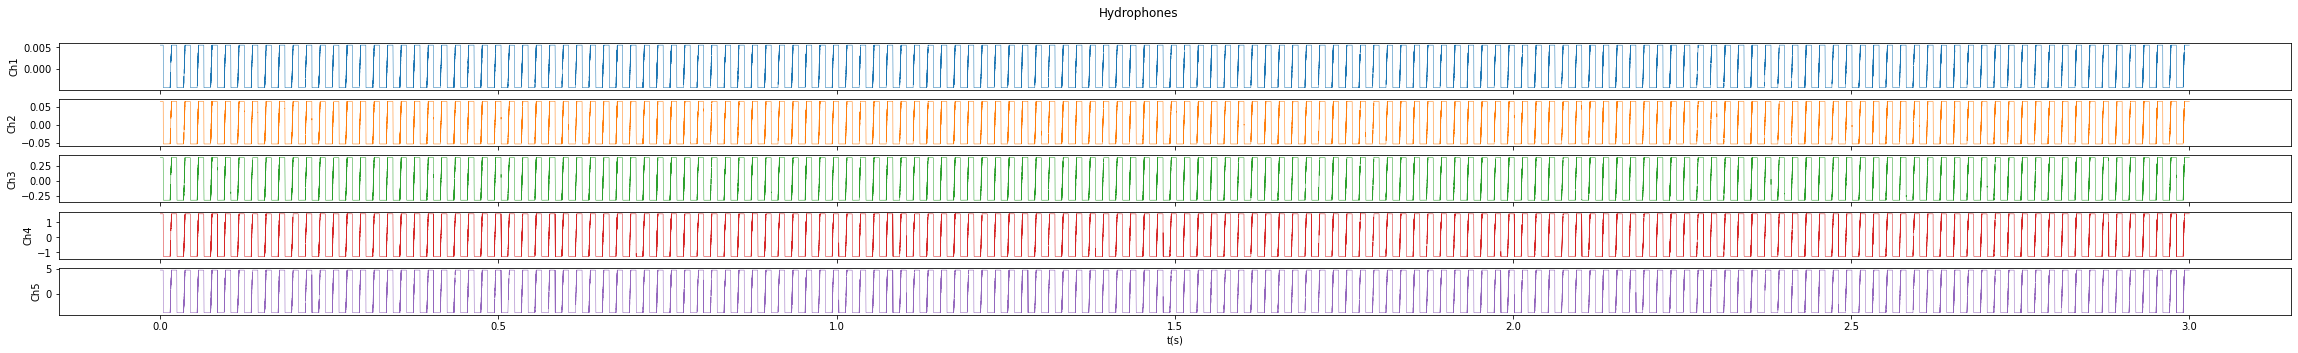

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(0, len(arr)//5)
loc = slice(0, int(3.0 / dt))
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.5)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
print(arr.shape, loc)

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(0, len(arr)//5)
loc = slice(1*len(arr)//5, 2*len(arr)//5)
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
from scipy.signal import iirfilter, lfilter, hilbert

In [ ]:
order = 6
pass_freqs = np.array((43e3, 47e3))

arr_filtered = lfilter(
    *iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='ba'), 
    arr)

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

loc = slice(0, len(arr)//5)
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
# f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(2*len(arr)//5, 3*len(arr)//5)
# for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
#   ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
#   ax.set_ylabel(f"Ch{i+1}")

# ax.set_xlabel("t(s)")
# f.suptitle("Hydrophones")
# plt.show()

In [ ]:
arr_env = np.abs(hilbert(arr_filtered))

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(2*len(arr)//5, 3*len(arr)//5)
loc = slice(1*len(arr)//5, 2*len(arr)//5)
for (i, ax), row, color in zip(enumerate(axs), arr_env.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(2*len(arr)//5, 3*len(arr)//5)
loc = slice(int(6.6 // dt), int(6.8 // dt))
for (i, ax), row, color in zip(enumerate(axs), arr_filtered.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(40,5), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(2*len(arr)//5, 3*len(arr)//5)
loc = slice(int(6.6 // dt), int(6.8 // dt))
for (i, ax), row, color in zip(enumerate(axs), arr_env.T, colors):
  ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.2)
  ax.set_ylabel(f"Ch{i+1}")

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

0

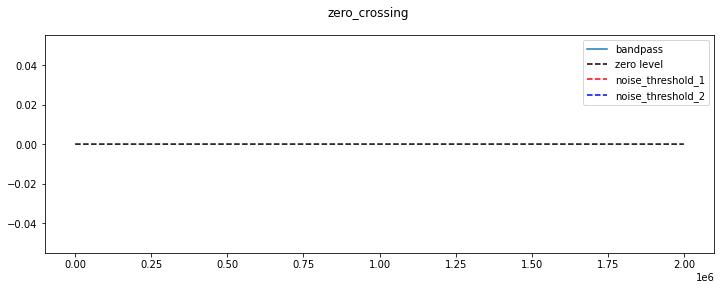

In [ ]:
Est_ZC_stage_1(arr[:int(2.0 / dt),0], int(0.005 / dt), fs, 100, run_plot=True, plot_title='zero_crossing')

In [ ]:
_ * dt

0.0

0

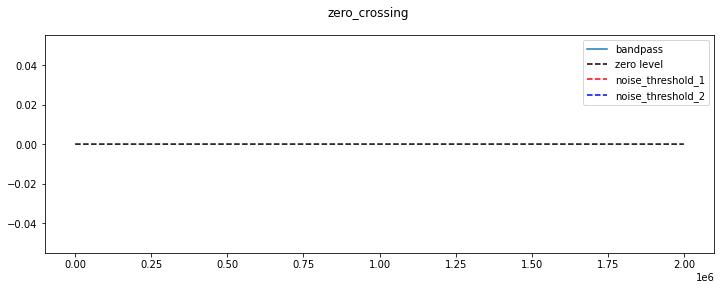

In [ ]:
Est_ZC_stage_1(arr[:int(2.0 / dt),1], int(0.005 / dt), fs, 100, run_plot=True, plot_title='zero_crossing')

0

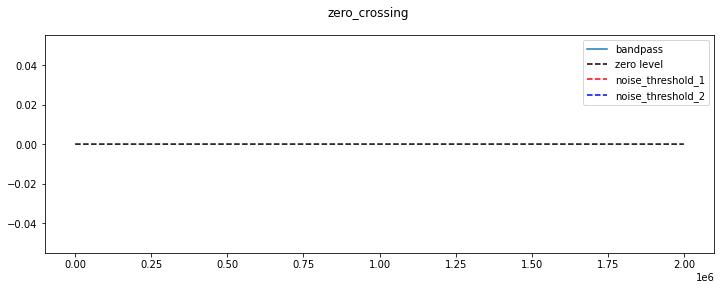

In [ ]:
Est_ZC_stage_1(arr[:int(2.0 / dt),2], int(0.005 / dt), fs, 100, run_plot=True, plot_title='zero_crossing')

0

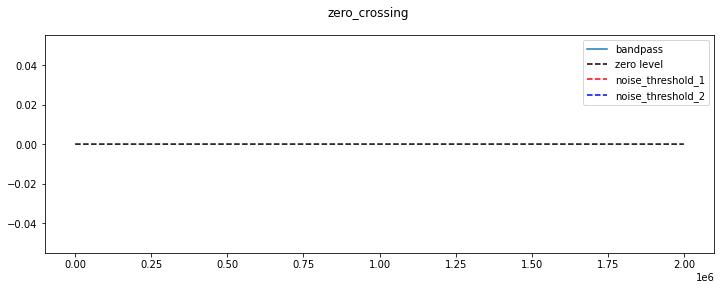

In [ ]:
Est_ZC_stage_1(arr[:int(2.0 / dt),3], int(0.005 / dt), fs, 100, run_plot=True, plot_title='zero_crossing')

0

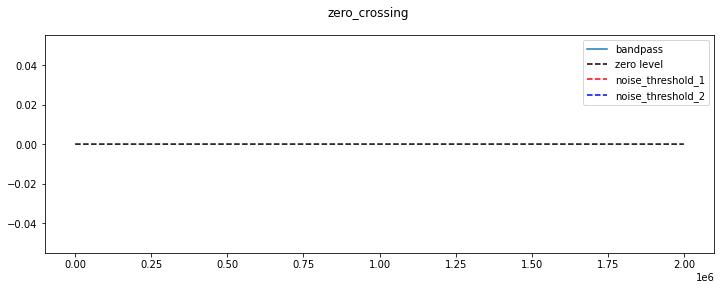

In [ ]:
Est_ZC_stage_1(arr[:int(2.0 / dt),4], int(0.005 / dt), fs, 100, run_plot=True, plot_title='zero_crossing')

In [ ]:
indices = np.array([415423, 415596, 415596, 415729, 415432])

In [ ]:
ts = indices * dt

In [ ]:
ts

In [ ]:
min(_)

In [ ]:
ind = np.array([0.415596, 0.415596, 0.415729]) - 0.41523

In [ ]:
ind  * 1500

In [ ]:
0.6 * np.sqrt(2)

## Remove AC Noise

In [ ]:
import pywt
from scipy.signal import iirfilter, sosfilt, hilbert

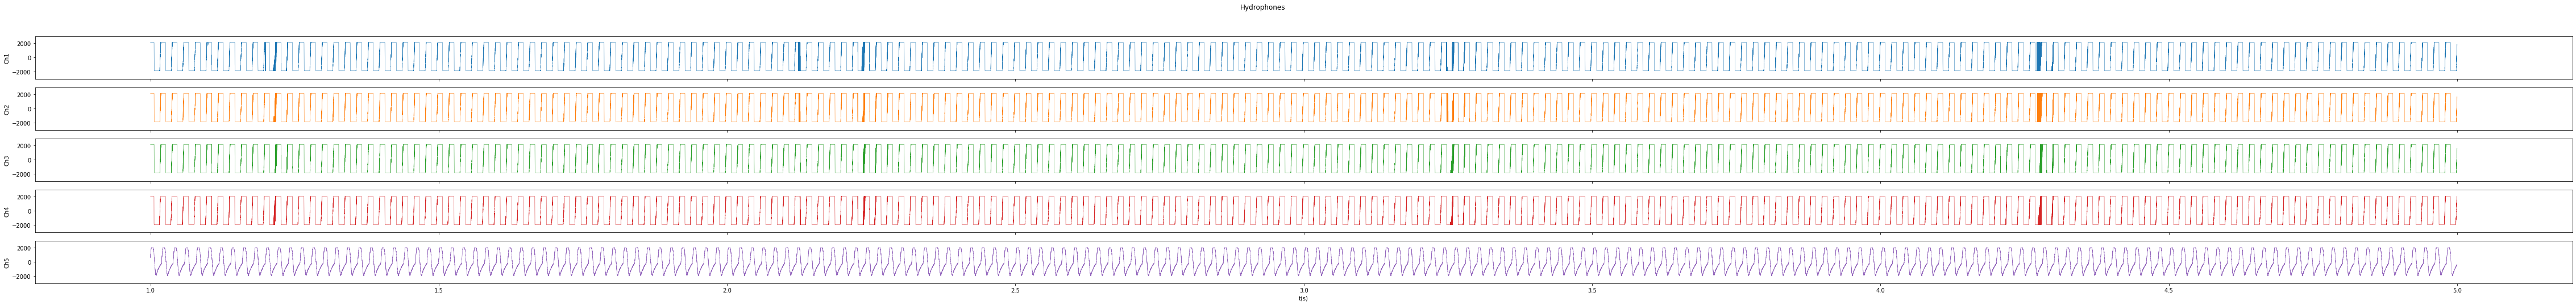

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(80,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(0, len(arr)//5)
loc = slice(int(10.0 / dt), int(13.0 / dt))
loc = slice(int(1.0 / dt), int(5.0 / dt))
for (i, ax), row, color in zip(enumerate(axs), arr.T, colors):
  ax.plot(t[loc], row[loc] - row.mean(), label=f"Ch{i+1}", color=color, linewidth=0.5)
  ax.set_ylabel(f"Ch{i+1}")
  ax.set_ylim(-3000,3000)

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
order = 6
pass_freqs = np.array((40e3, 50e3))

arr_filt = sosfilt(
    iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='sos'), 
    arr - arr.mean(axis=0))

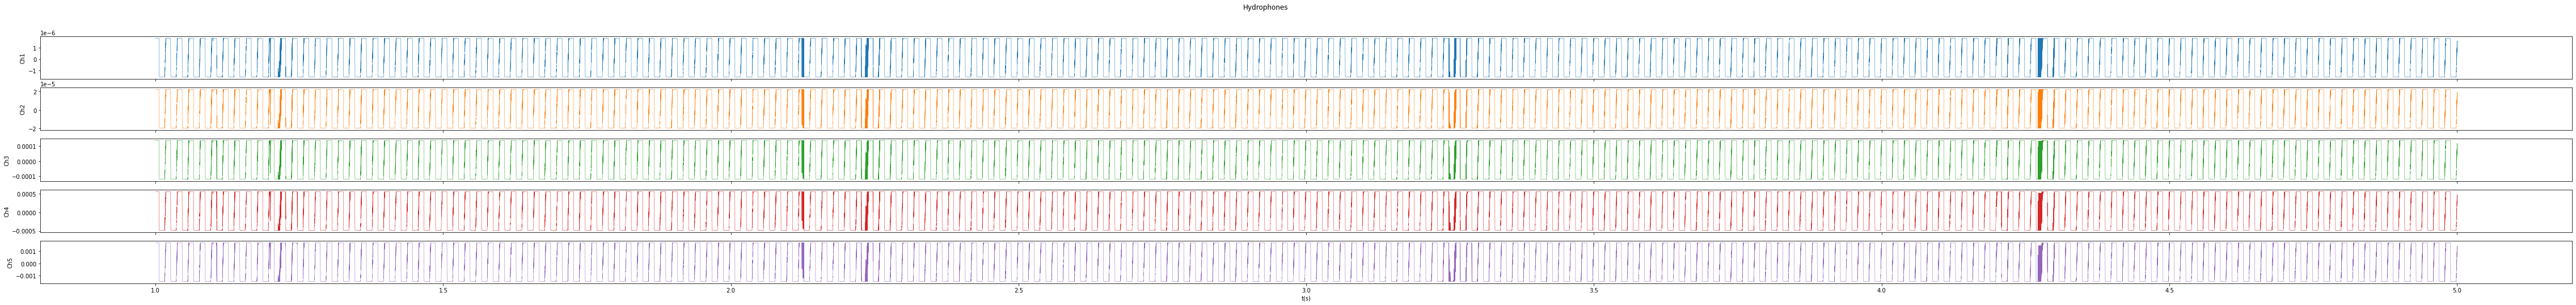

In [ ]:
f, axs = plt.subplots(arr.shape[1], 1, figsize=(80,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(0, len(arr)//5)
loc = slice(int(10.0 / dt), int(13.0 / dt))
loc = slice(int(1.0 / dt), int(5.0 / dt))

for (i, ax), row, color in zip(enumerate(axs), arr_filt.T, colors):
  ax.plot(t[loc], row[loc] - row.mean(), label=f"Ch{i+1}", color=color, linewidth=0.5)
  ax.set_ylabel(f"Ch{i+1}")
#   ax.set_ylim(-3000,3000)

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
loc = slice(int(fs * 1), int(fs * 5))
data = arr[loc, 0]
ts = t[loc]

data.shape,data.mean()

((4000000,), -135.9181135)

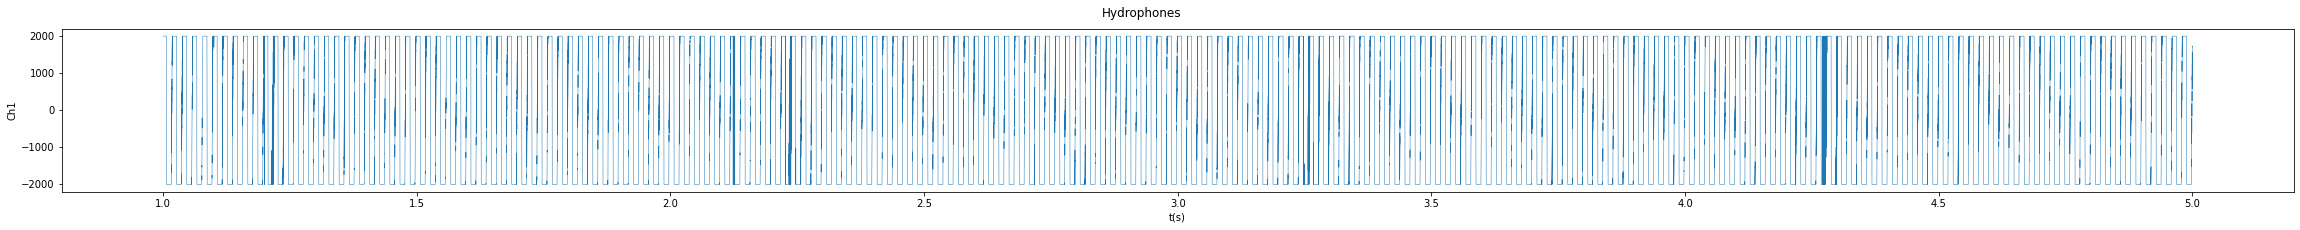

In [ ]:
f = plt.figure(figsize=(40,3))
ax = f.gca()
loc = slice(int(1.0 / dt), int(5.0 / dt))
ax.plot(ts, data,  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
scale = np.linspace(5,5000, 50)
f = pywt.scale2frequency('mexh', scale)/dt
f[-1], f[0]

(50.00000000000001, 50000.00000000001)

In [ ]:
coef, freqs=pywt.cwt(data,scale, 'mexh', sampling_period=dt, method='fft')

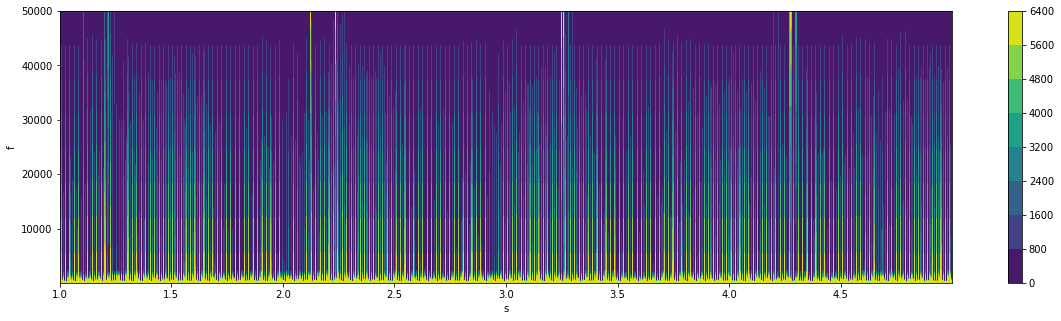

In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(ts[::500], freqs, np.clip(np.abs(coef[:, ::500]), 0, 6000))
# plt.contourf(t[loc][::500], f, np.clip((coef[:, ::500]), -6000, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()

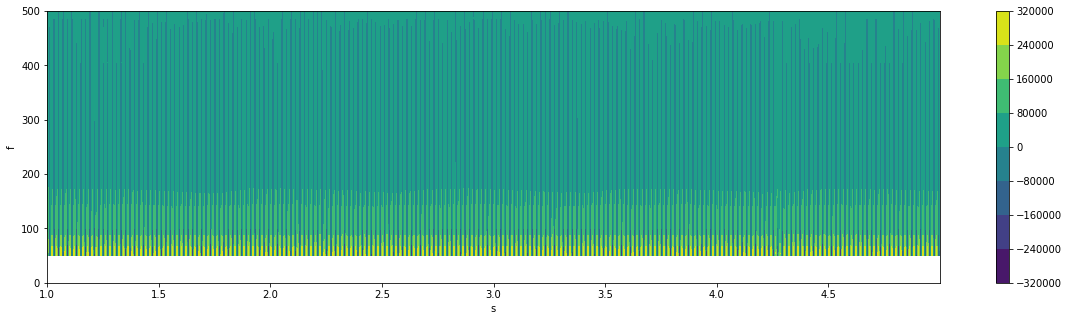

In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(t[loc][::500], f, coef[:, ::500])
plt.xlabel('s')
plt.ylabel('f')
plt.ylim(0, 500)
plt.colorbar()

In [ ]:
order = 6
pass_freqs = np.array((40e3, 50e3))

lp_data = sosfilt(
    iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='sos'), 
    data - data.mean())

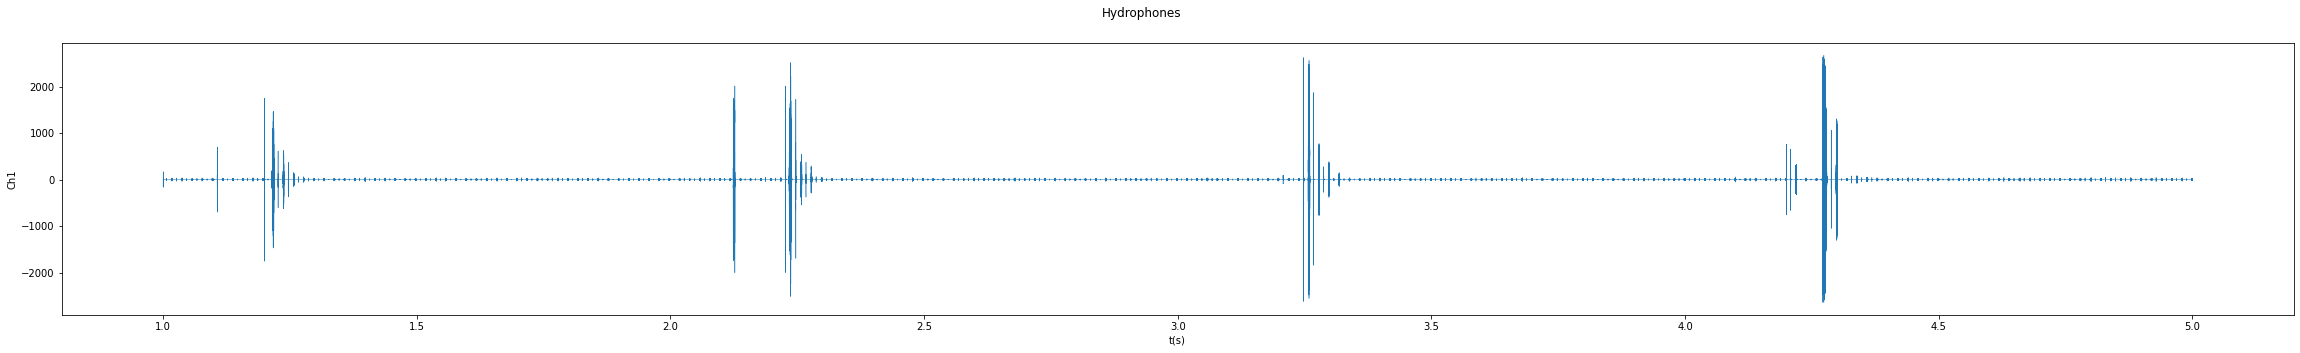

In [ ]:
f = plt.figure(figsize=(40,5))
ax = f.gca()
loc = slice(0, data.shape[0] // 5)
ax.plot(ts, lp_data,  linewidth=0.5)    
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
scale = np.linspace(5,5000, 50)
f = pywt.scale2frequency('mexh', scale)/dt
print(f[-1], f[0])
coef, freqs=pywt.cwt(lp_data,scale, 'mexh', sampling_period=dt, method='fft')

50.00000000000001 50000.00000000001


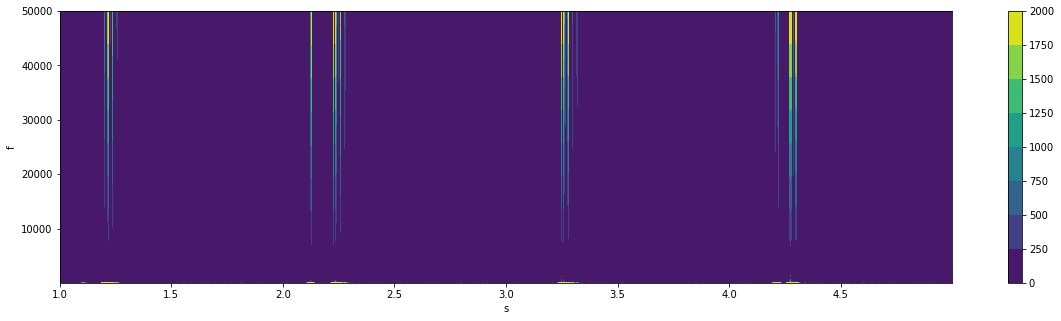

In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(ts[::500], f, np.clip(np.abs(coef[:, ::500]), 0, 2000))
# plt.contourf(t[loc][::500], f, np.clip((coef[:, ::500]), -6000, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()

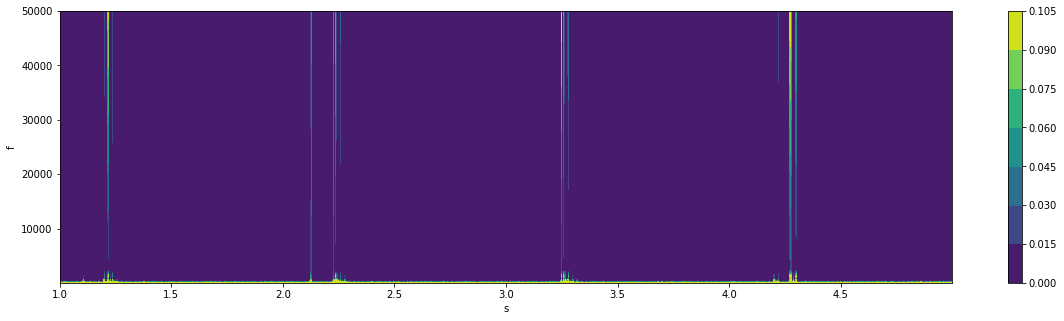

In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(ts[::500], f, np.clip(np.abs(coef[:, ::500] / freqs[:, None]), 0, 0.1))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()

(10.0, 500.0)

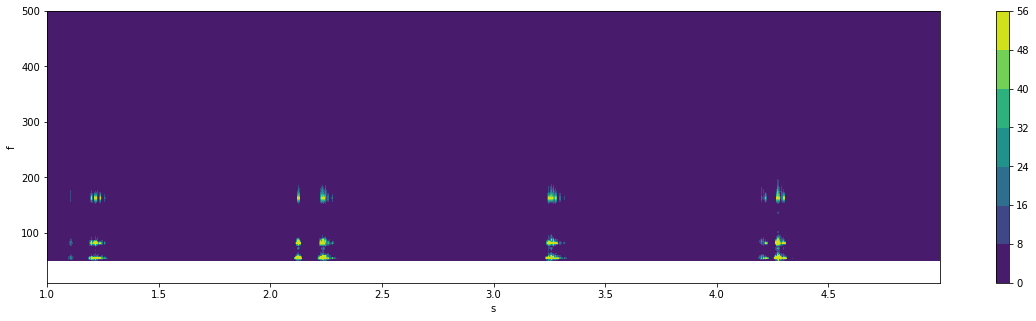

In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(ts[::500], f, np.clip(np.abs(coef[:, ::500] / freqs[:, None]), 0, 50))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()
plt.ylim(10, 500)

In [ ]:
scale = np.linspace(1,5000, 50)
f = pywt.scale2frequency('mexh', scale)/dt
print(f[-1], f[0])
coef, freqs=pywt.cwt(lp_data,scale, 'mexh', sampling_period=dt, method='fft')

50.00000000000001 250000.0


Text(0, 0.5, 'f')

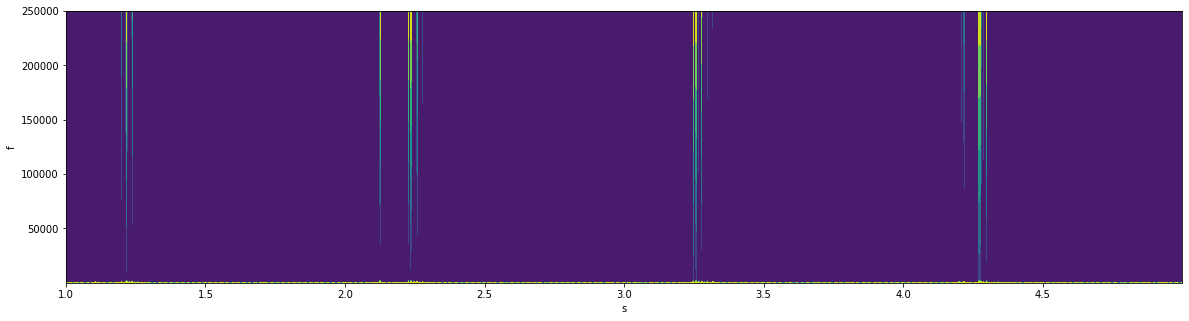

In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(ts[::500], f, np.clip(np.abs(coef[:, ::500]), 0, 100))
# plt.contourf(t[loc][::500], f, np.clip((coef[:, ::500]), -6000, 6000))
plt.xlabel('s')
plt.ylabel('f')

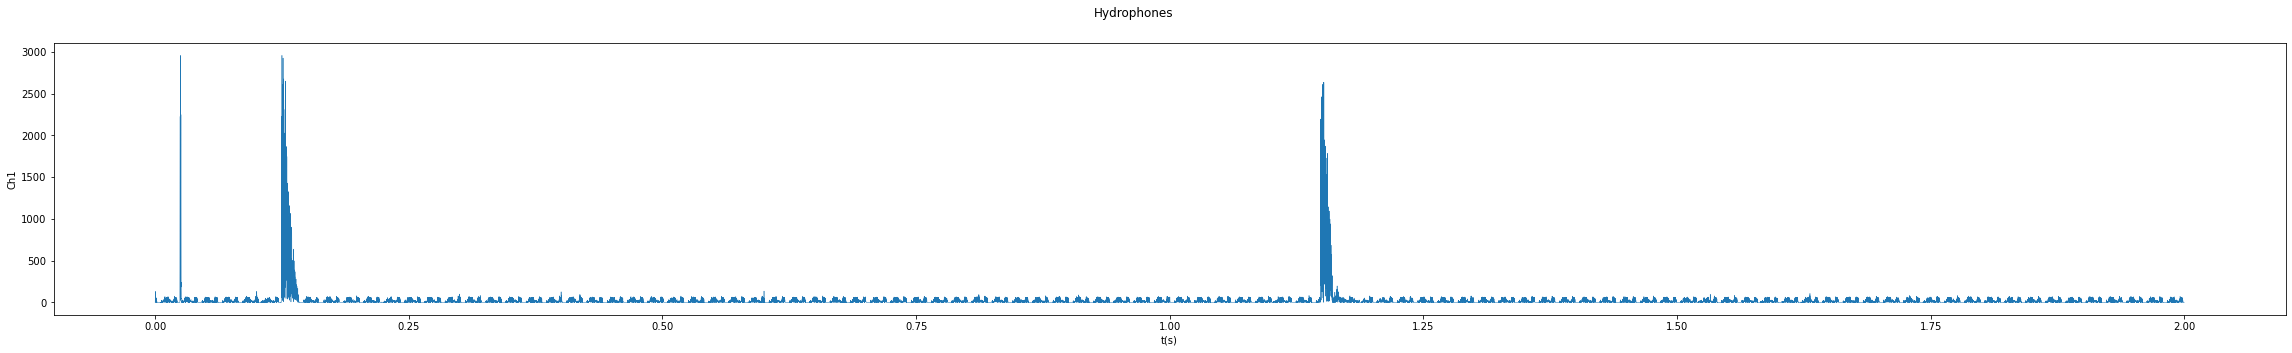

In [ ]:
f = plt.figure(figsize=(40,5))
ax = f.gca()
loc = slice(0, data.shape[0] // 5)
ax.plot(t[loc],np.abs(hilbert(lp_data[loc])),  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

Signal is wide band, hence the hilbert transform wont work.

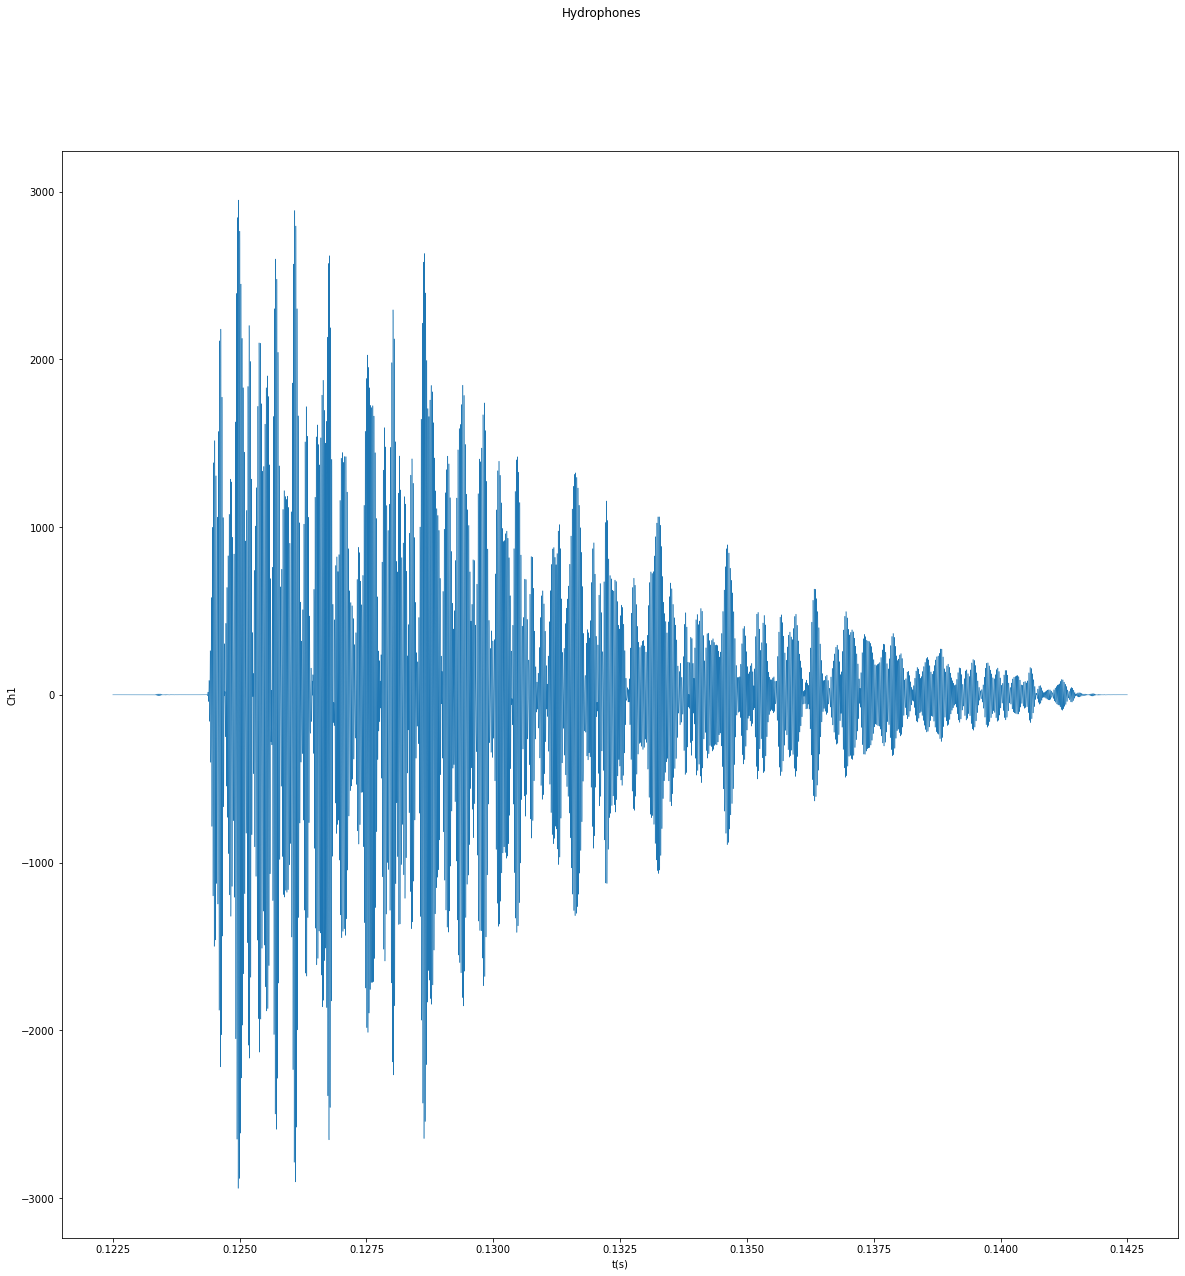

In [ ]:
f = plt.figure(figsize=(20,20))
ax = f.gca()
loc = slice(int(fs * 0.1225), int(fs * 0.1425))
ax.plot(t[loc],lp_data[loc],  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

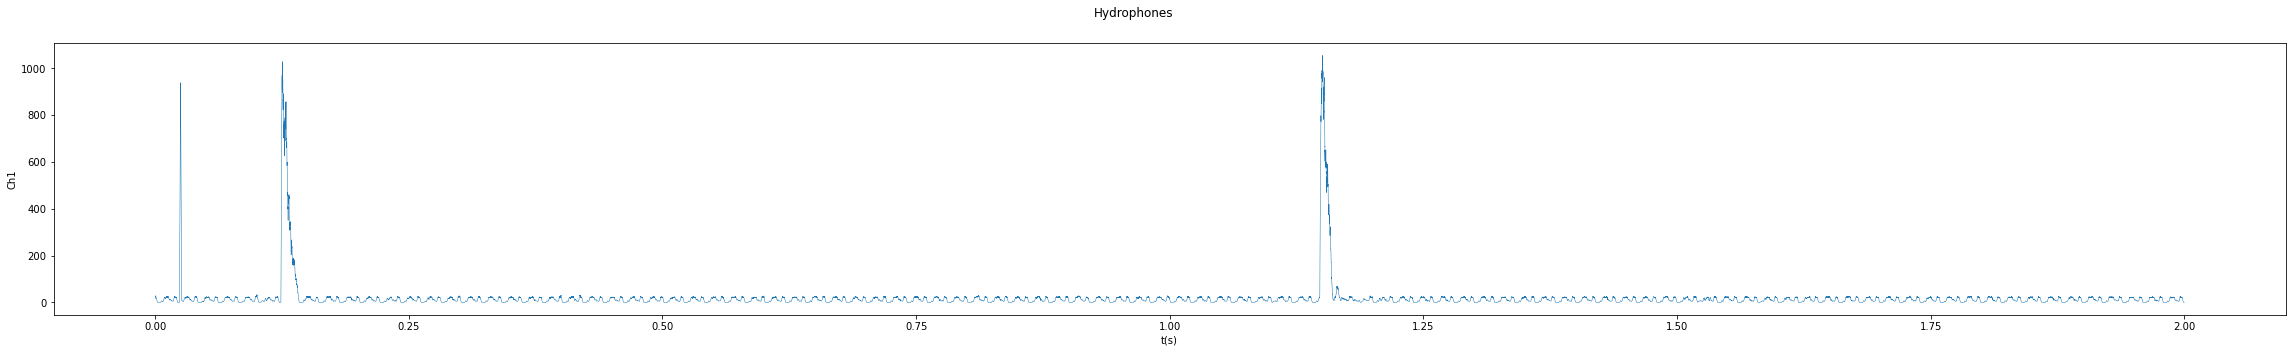

In [ ]:
loc = slice(0, data.shape[0] // 5)

w = int(1e-3 * fs)
sig = np.convolve(np.abs(lp_data[loc]), np.ones(w), 'same') / w

f = plt.figure(figsize=(40,5))
ax = f.gca()
ax.plot(t[loc], sig,  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()